In [1]:
import numpy
import matplotlib.pyplot as plt
import texplot
from glob import glob
from pprint import pprint
from os.path import join

In [2]:
# =======
# get eig
# =======

def get_eig(filename):
    data = numpy.load(filename, allow_pickle=True)['res'].item()
    eig = data['eig']
    subsize = data['subsize']
    wall_time = data['wall_time']
    return subsize, eig, wall_time


# ==========
# read files
# ==========

def read_files(dir_, filename):

    filenames = sorted(glob(join(dir_, filename)))
    pprint(filenames)
    print('')
    
    eigs = []
    subsizes = []
    wall_times = []
    for filename in filenames:
        subsize, eig, wall_time = get_eig(filename)
        subsizes.append(subsize)
        eigs.append(eig)
        wall_times.append(wall_time)
        print(f'wall_time: {wall_time/3600:>0.2f} hr')
    
    wall_times = numpy.array(wall_times)

    return subsizes, eigs, filenames

In [3]:
# ===============
# hist of log var
# ===============

def hist(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """
    
    u = eig

    if clip_x is not None:
        u = u[numpy.logical_and(u >= clip_x[0], u <= clip_x[1])]
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# ===============
# hist of log var
# ===============

def hist_of_log_var(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# =================
# hist in log scale
# =================

def hist_in_log_scale(eig, nbins, clip_x=None):
    """
    Histogram of a variable itself, but in log scale.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = 10.0**u_mid
    density = counts / lambda_
    return lambda_, density


# ============
# get all hist
# ============

def get_all_hist(subsizes, eigs, clip_x):
    
    log_xs = []
    log_rhos = []
    xs = []
    rhos = []
    print('')
    
    for subsize, eig in zip(subsizes, eigs):
        
        nbins = int(numpy.log(subsize) * 15)
        print(f'nbins: {nbins}')
        
        # x, rho = hist_in_log_scale(eig, nbins)
        # x, rho = hist(eig, nbins, clip_x=[1e-2, 1e1])
        x, rho = hist_in_log_scale(eig, nbins, clip_x=clip_x)
        xs.append(x)
        rhos.append(rho)
        
        log_x, log_rho = hist_of_log_var(eig, nbins, clip_x=clip_x)
        log_xs.append(log_x)
        log_rhos.append(log_rho)
    print('')

    return xs, rhos, log_xs, log_rhos

In [4]:
# ====
# Plot
# ====

def plot(dir_, filename, clip_x, clip_y, title, save_filename, d):
    
    subsizes, eigs, filenames = read_files(dir_, filename)
    xs, rhos, log_xs, log_rhos = get_all_hist(subsizes, eigs, clip_x)

    x_min = min([x[0] for x in xs])
    x_max = max([x[-1] for x in xs])
    log_x_min = min([log_x[0] for log_x in log_xs])
    log_x_max = max([log_x[-1] for log_x in log_xs])
    
    num_plots = len(eigs)
    cmap = plt.get_cmap('Reds')
    colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]
    
    with texplot.theme(use_latex=True):
        fig, ax = plt.subplots(figsize=(9, 3.4), ncols=2)


        for i  in range(len(eigs)):

            rho_ = rhos[i]
            if clip_y is not None:
                rho_[numpy.logical_or(rho_ < clip_y[0], rho_ > clip_y[1])] = numpy.nan
            
            n = int(numpy.log2(subsizes[i] // 10) + 0.5)
            ax[0].plot(xs[i], rho_, color=colors[i], label=f'$n = {{{d}}} \\times 2^{{{n}}}$')
            ax[1].plot(log_xs[i], log_rhos[i], color=colors[i], label=f'$n = {{{d}}} \\times 2^{{{n}}}$')
    
        ax[0].legend(fontsize='x-small')
        if clip_x is None:
            ax[0].set_xlim([x_min, x_max])
        else:
            ax[0].set_xlim([x_min, x_max])
            # ax[0].set_xlim([clip_x[0], clip_x[1]])
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$\rho(\lambda)$')
        ax[0].set_title(r' (a) ESD of $\mathbf{K}$')
    
        ax[1].legend(fontsize='x-small')
        if clip_x is None:
            ax[1].set_xlim([log_x_min, log_x_max])
        else:
            ax[1].set_xlim([numpy.log10(clip_x[0]), numpy.log10(clip_x[1])])
        ax[1].set_ylim(bottom=0)
        # ax[1].set_xscale('log')
        # ax[1].set_yscale('log')
        ax[1].set_xlabel(r'$\log_{10}(\lambda)$')
        # ax[1].set_xlabel(r'$\lambda$')
        ax[1].set_ylabel(r'$\rho(\log_{10}(\lambda))$')
        ax[1].set_title(r'(b) ESD of $\log_{10}(\mathbf{K})$')

        if title is not None:
            fig.suptitle(title, y=0.93)
            
        plt.tight_layout()
        # plt.show()

        texplot.show_or_save_plot(plt, default_filename=save_filename,
                                  transparent_background=True, dpi=200,
                                  show_and_save=True, verbose=True)

['././data/cifar_resnet50_fp64_p08.npz',
 '././data/cifar_resnet50_fp64_p09.npz',
 '././data/cifar_resnet50_fp64_p10.npz',
 '././data/cifar_resnet50_fp64_p11.npz',
 '././data/cifar_resnet50_fp64_p12.npz',
 '././data/cifar_resnet50_fp64_p13.npz',
 '././data/cifar_resnet50_fp64_p14.npz']

wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.01 hr
wall_time: 0.07 hr
wall_time: 0.48 hr
wall_time: 3.60 hr
wall_time: 15.90 hr

nbins: 117
nbins: 128
nbins: 138
nbins: 148
nbins: 159
nbins: 169
nbins: 180

Plot saved to "/home/sia/work/scripts/free_decompression/ntk/./plot-tmp/cifar_resnet50_fp64_esd.pdf".


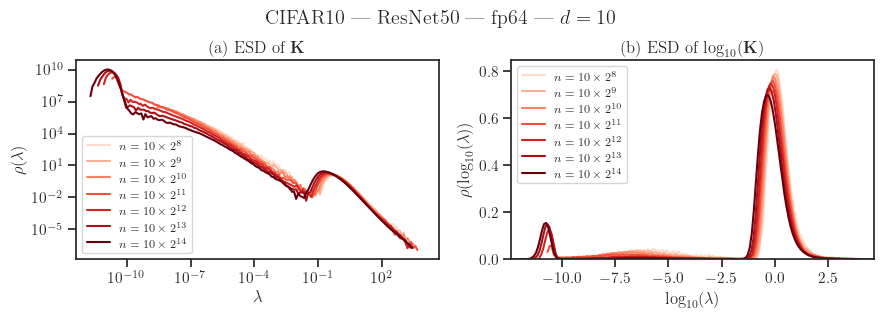

In [5]:
dir_ = '.'
filename = './data/cifar_resnet50_fp64_p*.npz'
clip_x = None
clip_y = [1e-7, numpy.inf]
title = 'CIFAR10 | ResNet50 | fp64 | $d=10$'
save_filename = './plot-tmp/cifar_resnet50_fp64_esd.pdf'
d = 10

plot(dir_, filename, clip_x, clip_y, title, save_filename, d)

['././data/cifar_resnet50_fp64_l9_p08.npz',
 '././data/cifar_resnet50_fp64_l9_p08_new.npz',
 '././data/cifar_resnet50_fp64_l9_p09.npz',
 '././data/cifar_resnet50_fp64_l9_p09_new.npz',
 '././data/cifar_resnet50_fp64_l9_p10.npz',
 '././data/cifar_resnet50_fp64_l9_p10_new.npz',
 '././data/cifar_resnet50_fp64_l9_p11.npz',
 '././data/cifar_resnet50_fp64_l9_p11_new.npz',
 '././data/cifar_resnet50_fp64_l9_p12.npz',
 '././data/cifar_resnet50_fp64_l9_p12_new.npz',
 '././data/cifar_resnet50_fp64_l9_p13.npz',
 '././data/cifar_resnet50_fp64_l9_p13_new.npz']

wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.01 hr
wall_time: 0.01 hr
wall_time: 0.05 hr
wall_time: 0.05 hr
wall_time: 0.29 hr
wall_time: 0.30 hr
wall_time: 2.43 hr
wall_time: 2.37 hr

nbins: 116
nbins: 116
nbins: 126
nbins: 126
nbins: 136
nbins: 136
nbins: 147
nbins: 147
nbins: 157
nbins: 157
nbins: 168
nbins: 168

Plot saved to "/home/sia/work/scripts/free_decompression/ntk/./plot-tmp/cifar_resnet5

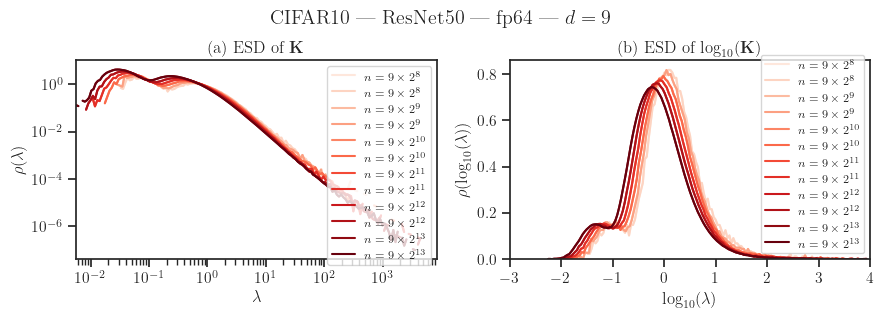

In [6]:
dir_ = '.'
filename = './data/cifar_resnet50_fp64_l9_p*.npz'
clip_x = [1e-3, 1e4]
clip_y = [1e-7, numpy.inf]
title = 'CIFAR10 | ResNet50 | fp64 | $d=9$'
save_filename = './plot-tmp/cifar_resnet50_fp64_l9_esd.pdf'
d = 9

plot(dir_, filename, clip_x, clip_y, title, save_filename, d)

['././data/cifar_resnet50_fp64_l9_p08_new.npz',
 '././data/cifar_resnet50_fp64_l9_p09_new.npz',
 '././data/cifar_resnet50_fp64_l9_p10_new.npz',
 '././data/cifar_resnet50_fp64_l9_p11_new.npz',
 '././data/cifar_resnet50_fp64_l9_p12_new.npz',
 '././data/cifar_resnet50_fp64_l9_p13_new.npz']

wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.01 hr
wall_time: 0.05 hr
wall_time: 0.30 hr
wall_time: 2.37 hr

nbins: 116
nbins: 126
nbins: 136
nbins: 147
nbins: 157
nbins: 168

Plot saved to "/home/sia/work/scripts/free_decompression/ntk/./plot-tmp/cifar_resnet50_fp64_l9_esd.pdf".


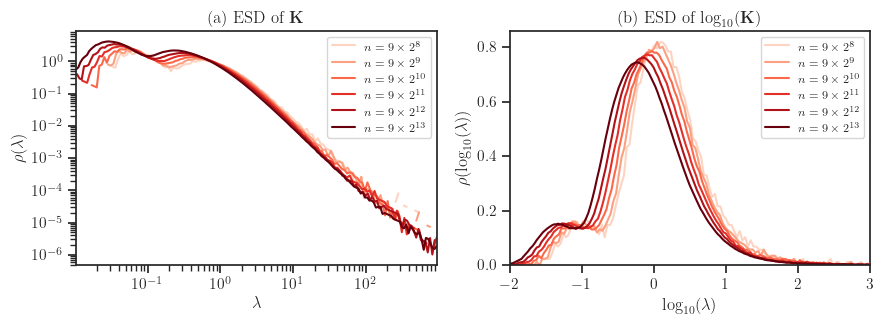

In [7]:
dir_ = '.'
filename = './data/cifar_resnet50_fp64_l9_p*_new.npz'
clip_x = [1e-2, 1e3]
clip_y = [1e-7, numpy.inf]
# title = 'CIFAR10 | ResNet50 | fp64 | $d=9$'
title = None
save_filename = './plot-tmp/cifar_resnet50_fp64_l9_esd.pdf'
d = 9

plot(dir_, filename, clip_x, clip_y, title, save_filename, d)